# Summary Of Science

In [1]:
import requests
import zipfile
import requests
import io
import zipfile
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
import html
from collections import defaultdict, Counter
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import ngrams
from rouge_score import rouge_scorer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch


stop_set = set(stopwords.words('english')) #create a set of english stopwords
sns.set_style("dark")
plot_dims = (16, 16)


In [17]:
!pip install transformers

In [16]:
#download data if we haven't already
if not os.path.isdir("data/nlp_data"): 
    url = "https://cs.stanford.edu/~myasu/projects/scisumm_net/scisummnet_release1.1__20190413.zip"
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall("data/nlp_data")
       print("File is unzipped in nlp_data folder") 
else:
    print("Data has already been downloaded")

Data has already been downloaded


## EDA

In [3]:
#get all raw text, break all papers into two parts -- Abstract and rest of document
#first get all filepaths
xmlfiles = []
for subdir, dirs, files in os.walk(r'nlp_data'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".xml"):
            xmlfiles.append(filepath)

In [4]:
#next parse all XML documents

def parse_xml_abstract(fp):
    """ parse an XML journal article into an abstract and the rest of the text
    """
    try:
        tree = ET.parse(fp)
    except Exception as e:
        return "","",str(e)
    root = tree.getroot()
    
    ab = []
    bod = []
    
    for child in root:
        if child.tag == "ABSTRACT":
            for block in child:
                ab.append(block.text)
        else:
            for block in child:
                bod.append(block.text)
                
    #convert from list --> string
    abstract = "\n".join(ab)
    body = "\n".join(bod)
    
    #decode html entities
    abstract = html.unescape(abstract)
    body = html.unescape(body)
    
    return abstract,body,""

raw_cols = []
for fp in xmlfiles:
    ab,bod,err = parse_xml_abstract(fp)
    if err:
        #print(fp, err)
        continue
    raw_cols.append([ab,bod,fp])

df = pd.DataFrame(raw_cols, columns=["abstract", "body", "filepath"])
df

,abstract,body,filepath
0,We present a method for extracting parts of ob...,We present a method of extracting parts of obj...,nlp_data/scisummnet_release1.1__20190413/top10...
1,We describe a series of five statistical model...,We describe a series of five statistical model...,nlp_data/scisummnet_release1.1__20190413/top10...
2,Previous work has shown that Chinese word segm...,Word segmentation is considered an important f...,nlp_data/scisummnet_release1.1__20190413/top10...
3,We examine the viability of building large pol...,Polarity lexicons are large lists of phrases t...,nlp_data/scisummnet_release1.1__20190413/top10...
4,Extracting semantic relationships between enti...,Extraction of semantic relationships between e...,nlp_data/scisummnet_release1.1__20190413/top10...
...,...,...,...
1004,"In statistical machine translation, correspond...","In statistical machine translation, correspond...",nlp_data/scisummnet_release1.1__20190413/top10...
1005,We have developed a new program called alignin...,Aligning parallel texts has recently received ...,nlp_data/scisummnet_release1.1__20190413/top10...
1006,We present an approach to pronoun resolution b...,Pronoun resolution is a difficult but vital pa...,nlp_data/scisummnet_release1.1__20190413/top10...
1007,We use logical inference techniques for recogn...,Recognising textual entailment (RTE) is the ta...,nlp_data/scisummnet_release1.1__20190413/top10...


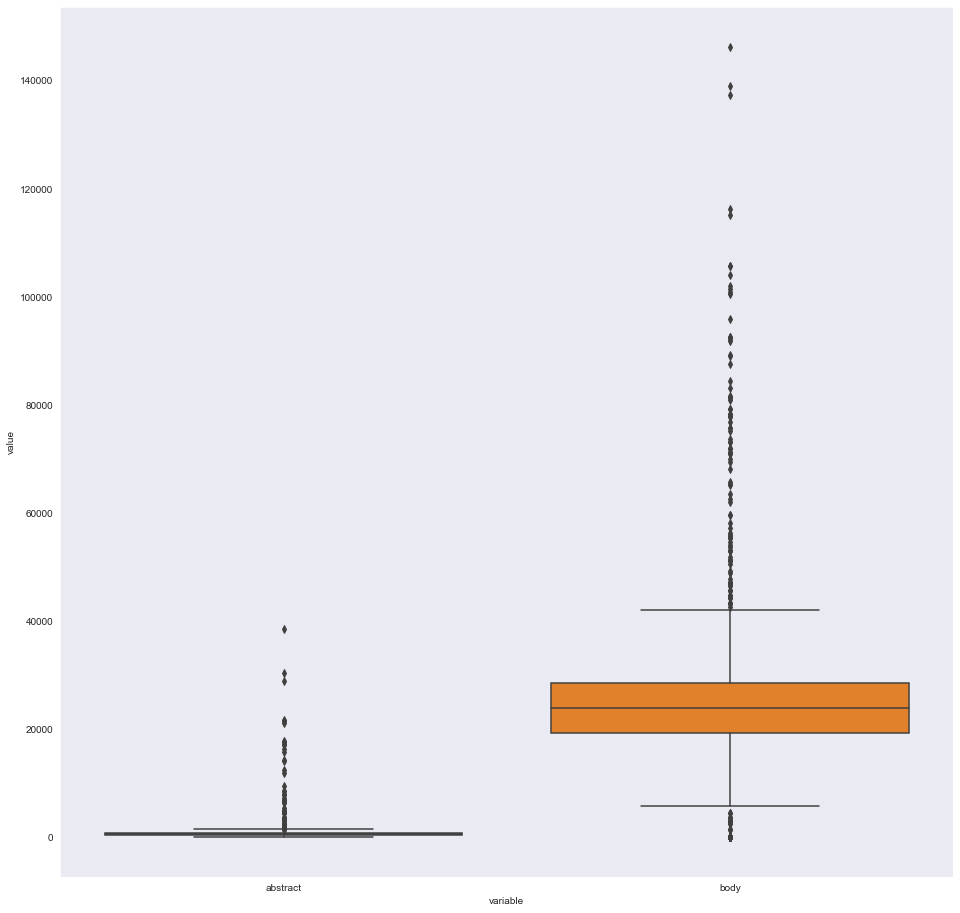

Average Abstract Length: 1084
Average Body Length: 26168


In [5]:
#find mean of abstracts body
#find total lengths

length_data = {
    "abstract":[],
    "body":[],
}

abstract_corpus = []
body_corpus = []

for index, row in df.iterrows():
    length_data["abstract"].append(len(row["abstract"]))
    length_data["body"].append(len(row["body"]))
    abstract_corpus.append(row["abstract"].lower())
    body_corpus.append(row["body"].lower())

ld = pd.DataFrame(length_data)
fig, ax = plt.subplots(figsize=plot_dims)

sns.boxplot(x="variable", y="value", data=pd.melt(ld))
plt.show()

def Average(lst): 
    return round(sum(lst) / len(lst)) 

print("Average Abstract Length: {}".format(Average(length_data["abstract"])))
print("Average Body Length: {}".format(Average(length_data["body"])))


,abstract
count,1009.000000
mean,1083.992071
std,2691.084790
min,0.000000
50%,653.000000
95%,1862.400000
max,38470.000000


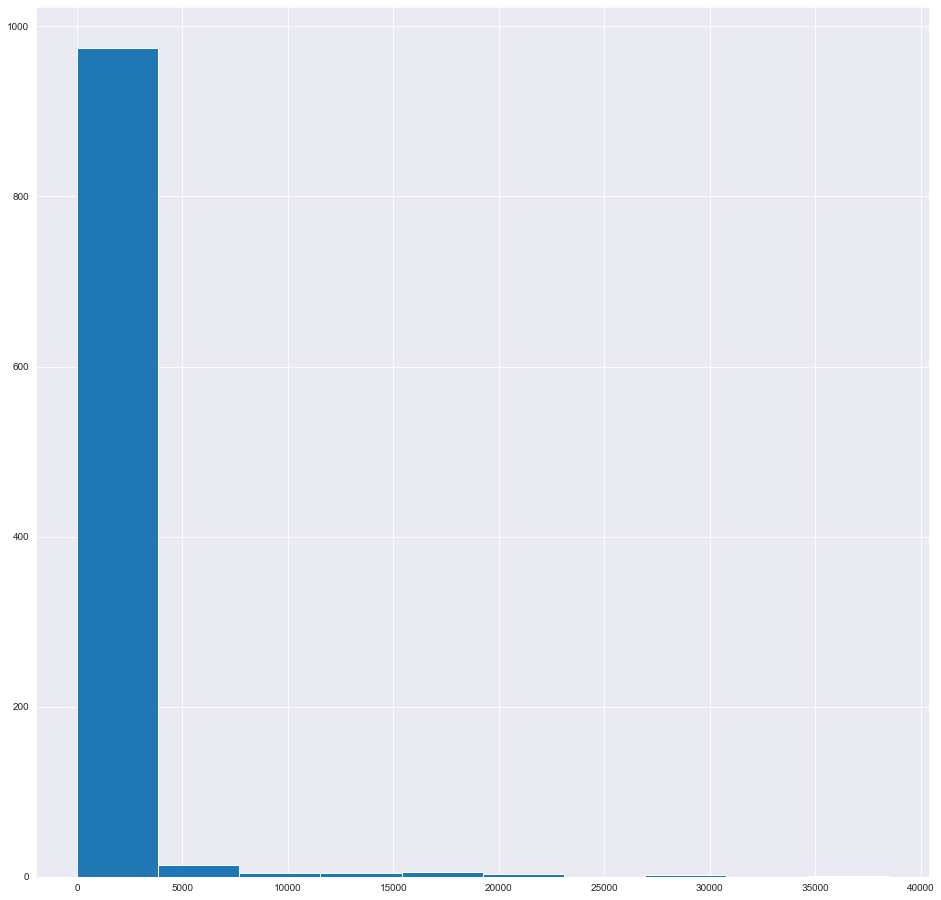

In [6]:
fig, ax = plt.subplots(figsize=plot_dims)
df['abstract'].str.len().hist()
abs_lengths = pd.DataFrame(df["abstract"].str.len())
abs_lengths.describe(percentiles=[0.95])


,body
count,1009.000000
mean,26168.062438
std,17781.772611
min,0.000000
50%,23958.000000
95%,63127.800000
max,146332.000000


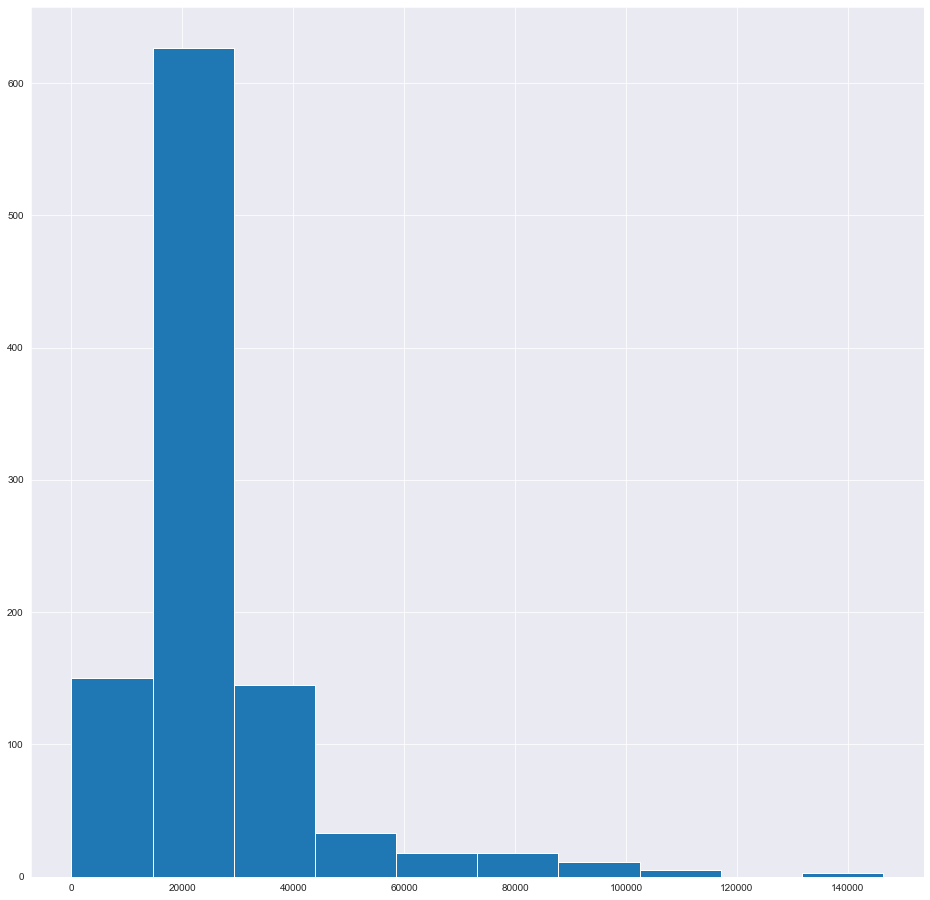

In [7]:
fig, ax = plt.subplots(figsize=plot_dims)
df['body'].str.len().hist()
body_lengths = pd.DataFrame(df["body"].str.len())
body_lengths.describe(percentiles=[0.95])


<AxesSubplot:>

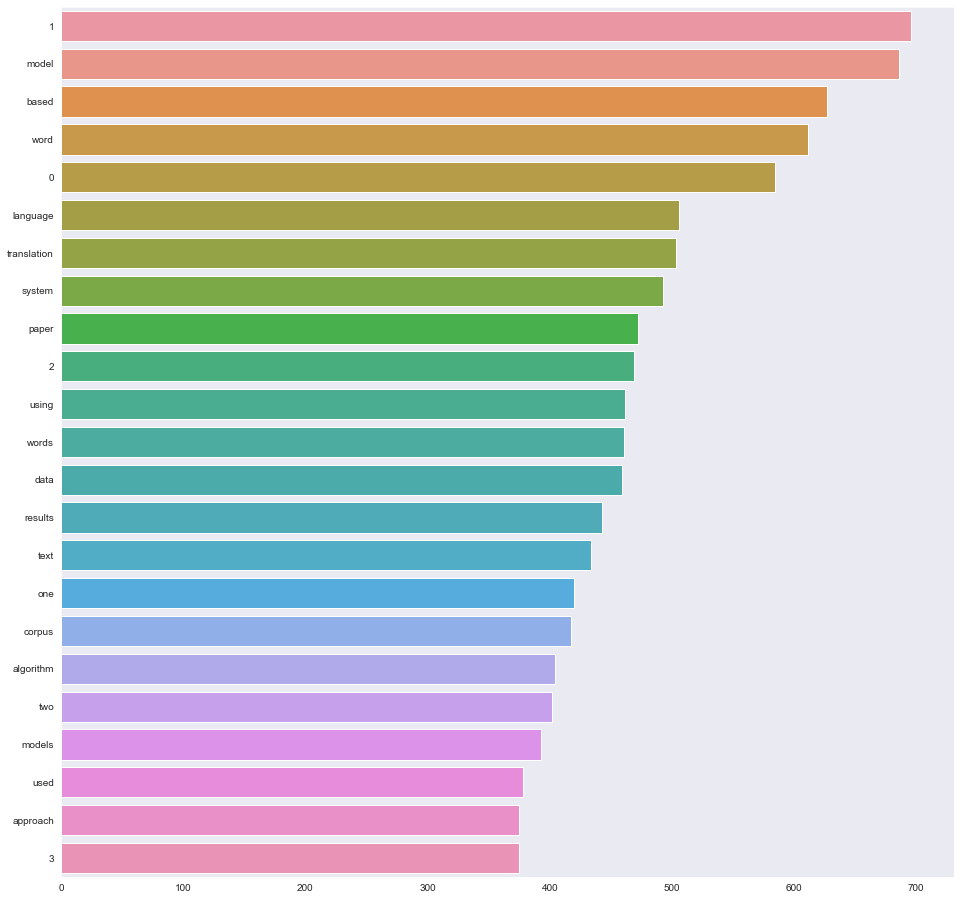

In [8]:
#find most common words in abstracts
abstract_words = re.findall(r"[\w']+", "\n".join(abstract_corpus))
counter = Counter(abstract_words)
most = counter.most_common()
x, y = [], []
for word,count in most[:50]:
    if (word not in stop_set):
        x.append(word)
        y.append(count)
fig, ax = plt.subplots(figsize=plot_dims)
sns.barplot(x=y,y=x)

## Baseline model

Using ROUGE-N we can count our generated summaries to our manual summaries by measuring the amount of N-Gram overlap in both pieces of text. [1]


In [9]:
#this was just an exercise to learn about how to implement a rouge-N system
# Rouge-N a scoring metric of similarity between sequences
#tokenize based on word boundaries, exclude punctuation
rouge_tokenizer = RegexpTokenizer('[a-zA-Z]\w+')

def rouge_n(pred_summary, summary, n=1):
    """ Given two sequences of text find the sum of n-gram co-occurence
        over the total possible n-gram co-occurences. 
        
        pred_summary: predicted summary, raw text (string)
        summary: reference summary, raw text (string)
    """
    
    ngram_summary = ngrams(rouge_tokenizer.tokenize(summary.lower()),n) #manual summary, ground truth
    ngram_pred = ngrams(rouge_tokenizer.tokenize(pred_summary.lower()),n) #generated summary
    
    cnt_summary = Counter()
    len_ngram_summary = 0
    for gram in ngram_summary:
        cnt_summary[gram] += 1
        len_ngram_summary += 1
    
    cnt_pred = Counter()
    for gram in ngram_pred:
        cnt_pred[gram] += 1
    
    #find sum of maximum co-occurence of ngrams over total possible n-grams
    #essentially measuring total similarity of these two pieces of text
    co_occurences = 0
    possible_occurences = len_ngram_summary
    for gram in cnt_pred:
        if gram in cnt_summary:
            #get max occurences
            if cnt_pred[gram] > cnt_summary[gram]:
                co_occurences += cnt_summary[gram]
            else:
                co_occurences += cnt_pred[gram]
    
    return co_occurences / possible_occurences

    
def test_rouge_n():
    tests = [
        {
            "pred":"This is a test",
            "summary":"This is a test",
            "ngram":1,
            "expected":1.0,
        },
        {
            "pred":"This is also test",
            "summary":"This is a test",
            "ngram":1,
            "expected":0.75,
        },
        {
            "pred":"This is a test",
            "summary":"This is a test",
            "ngram":2,
            "expected":1.0,
        },
        {
            "pred":"This is also test",
            "summary":"This is a test",
            "ngram":2,
            "expected":0.3333,
        },   
    ]
    for t in tests:
        score = rouge_n(t["pred"], t["summary"], n=t["ngram"])
        if score != t["expected"]:
            print("Expected: {}, Got: {}, Pred: {} Summary: {}".format(
                t["expected"], 
                score, 
                t["pred"],
                t["summary"],
            ))


test_rouge_n()


Expected: 0.75, Got: 1.0, Pred: This is also test Summary: This is a test
Expected: 0.3333, Got: 0.5, Pred: This is also test Summary: This is a test


In [15]:

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL','rougeLsum'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')
for k in scores:
    score = scores[k]
    print("{} : {}".format(k,score[0]))

rouge1 : 0.75
rouge2 : 0.2857142857142857
rougeL : 0.625
rougeLsum : 0.625


In [12]:
#baseline using pegasus
src_text = [
    """ PG&E stated it scheduled the blackouts in response to forecasts for high winds amid dry conditions. The aim is to reduce the risk of wildfires. Nearly 800 thousand customers were scheduled to be affected by the shutoffs which were expected to last through at least midday tomorrow."""
]

model_name = 'google/pegasus-xsum'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
assert tokenizer != None

model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)
batch = tokenizer.prepare_seq2seq_batch(src_text, truncation=True, padding='longest', return_tensors="pt").to(torch_device)
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
assert tgt_text[0] == "California's largest electricity provider has turned off power to hundreds of thousands of customers."

PreTrainedTokenizer(name_or_path='google/pegasus-xsum', vocab_size=96103, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask_2>', 'additional_special_tokens': ['<mask_1>', '<unk_2>', '<unk_3>', '<unk_4>', '<unk_5>', '<unk_6>', '<unk_7>', '<unk_8>', '<unk_9>', '<unk_10>', '<unk_11>', '<unk_12>', '<unk_13>', '<unk_14>', '<unk_15>', '<unk_16>', '<unk_17>', '<unk_18>', '<unk_19>', '<unk_20>', '<unk_21>', '<unk_22>', '<unk_23>', '<unk_24>', '<unk_25>', '<unk_26>', '<unk_27>', '<unk_28>', '<unk_29>', '<unk_30>', '<unk_31>', '<unk_32>', '<unk_33>', '<unk_34>', '<unk_35>', '<unk_36>', '<unk_37>', '<unk_38>', '<unk_39>', '<unk_40>', '<unk_41>', '<unk_42>', '<unk_43>', '<unk_44>', '<unk_45>', '<unk_46>', '<unk_47>', '<unk_48>', '<unk_49>', '<unk_50>', '<unk_51>', '<unk_52>', '<unk_53>', '<unk_54>', '<unk_55>', '<unk_56>', '<unk_57>', '<unk_58>', '<unk_59>', '<unk_60>', '<unk_61>', '<unk_62>

In [14]:
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration

model = TFPegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')
tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')

ARTICLE_TO_SUMMARIZE = (
"PG&E stated it scheduled the blackouts in response to forecasts for high winds "
"amid dry conditions. The aim is to reduce the risk of wildfires. Nearly 800 thousand customers were "
"scheduled to be affected by the shutoffs which were expected to last through at least midday tomorrow."
)
inputs = tokenizer([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='tf')

# Generate Summary
summary_ids = model.generate(inputs['input_ids'])
print([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

All the layers of TFPegasusForConditionalGeneration were initialized from the model checkpoint at google/pegasus-xsum.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFPegasusForConditionalGeneration for predictions without further training.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


["California's largest utility has cut power to hundreds of thousands of customers in an effort to reduce the risk of wildfires."]


## References

[1] Lin, C. (2004). ROUGE: A Package for Automatic Evaluation of Summaries. ACL 2004.